# refellips demo: Solid/Liquid
This demo presents an example use case for fitting multi-wavelength single-angle ellipsometry data for solid-liquid systems with refellips.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from refnx.analysis import CurveFitter
from refnx.reflect import Slab

In [3]:
# Will need to add the repo directory to sys.path (system specific)
sys.path.append('../')

from structureSE import RI
from dataSE import DataSE
from reflect_modelSE import ReflectModelSE
from objectiveSE import ObjectiveSE

### Import data

In [4]:
dname = 'WVASE_example_2nmSiO2_100nmPNIPAM_MultiWavelength_Water.dat'
data = DataSE(data=dname)
np.unique(data.wav)

array([400., 440., 480., 520., 560., 600., 640., 680., 720., 760., 800.])

### Build model

In [5]:
from refnx.reflect import Linear, Erf

si     = RI('../materials/silicon.csv')
sio2   = RI('../materials/silica.csv')
PNIPAM = RI('../materials/pnipam.csv')
air    = RI('../materials/air.csv')
h2o    = RI('../materials/water.csv')

PNIPAM_layer = PNIPAM(1000)
PNIPAM_layer.thick.setp(vary=True, bounds=(100,1500))
PNIPAM_layer.vfsolv.setp(vary=True, value=0.8, bounds=(0.1,1))
PNIPAM_layer.rough.setp(vary=True, value=100, bounds=(50,300))
PNIPAM_layer.interfaces = Erf()

struc = h2o() | PNIPAM_layer | sio2(20) | si()
struc.contract = 2
struc.solvent= h2o

model = ReflectModelSE(struc, wavelength=658)

# Fitting experimental data

### Model & data pre fit

[Text(0, 0.5, 'Delta')]

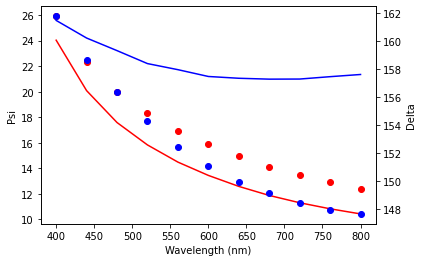

In [6]:
fig, ax = plt.subplots()
axt = ax.twinx()

psis = []
deltas = []
for dat in data:
    model.wav = dat._current_wav
    psi, delta = model([65])
    psis.append(psi)
    deltas.append(delta)

data.mask = np.ones_like(data.mask, dtype=bool)
ax.scatter(data.wav, data.psi, color='r')
axt.scatter(data.wav, data.delta, color='b')

ax.plot(data.wav, psis, color='r')
axt.plot(data.wav, deltas, color='b')

ax.set(ylabel='Psi', xlabel='Wavelength (nm)')
axt.set(ylabel='Delta')

In [7]:
objective = ObjectiveSE(model, data)

In [8]:
fitter = CurveFitter(objective)
fitter.fit(method='least_squares');

### Model & data post fit

[Text(0, 0.5, 'Delta')]

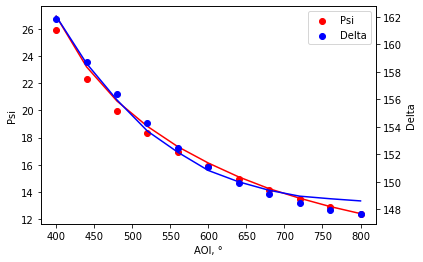

In [9]:
fig, ax = plt.subplots()
axt = ax.twinx()

psis = []
deltas = []
for dat in data:
    model.wav = dat._current_wav
    psi, delta = model([65])
    psis.append(psi)
    deltas.append(delta)

data.mask = np.ones_like(data.mask, dtype=bool)
p = ax.scatter(data.wav, data.psi, color='r')
d = axt.scatter(data.wav, data.delta, color='b')

ax.plot(data.wav, psis, color='r')
axt.plot(data.wav, deltas, color='b')

ax.legend(handles=[p,d], labels=['Psi', 'Delta'])
ax.set(ylabel='Psi', xlabel='AOI, °')
axt.set(ylabel='Delta')

### Refractive index profile

[Text(0, 0.5, 'Refractive index'), Text(0.5, 0, 'Distance from substrate (Å)')]

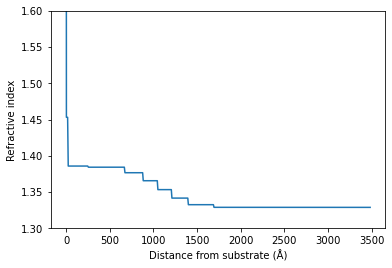

In [10]:
fig, ax = plt.subplots()
struc.reverse_structure = True
ax.plot(*struc.sld_profile())
struc.reverse_structure = False
ax.set_ybound(1.3,1.6)
ax.set(ylabel='Refractive index', xlabel='Distance from substrate (Å)')

In [11]:
for x in fitter.objective.model.parameters:
    print(x)

________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter: 'wavelength'  , value=800 (fixed)  , bounds=[-inf, inf]>
<Parameter:'delta offset' , value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  ' - rough'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:' - volfrac solvent', value=0 (fixed)  , bounds=[0.0, 1.0]>
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=1052.68 +/- 10.9 , bounds=[100.0, 1500.0]>
<Parameter:  ' - rough'   , value=300 +/- 17.1 , bounds=[50.0, 300.0]>
<Parameter:' - volfrac solvent', value=0.660409 +/- 0.00558, bounds